In [205]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os

from sklearn.ensemble import IsolationForest

from scipy.signal import butter, filtfilt

### Usefull Functions

In [206]:

def get_file_names(directory):
    file_names = []
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            file_names.append(filename)
    return file_names

In [207]:

def plot_outliers_isolation(df, outliers):
    """
    Plots the acceleration data with detected outliers highlighted.

    Args:
        df (pandas.DataFrame): The DataFrame containing the acceleration data.
        outliers (pandas.Series): A series indicating whether each data point is an outlier (-1) or an inlier (1).
    """
    # Select the acceleration columns
    accel_columns = ['params.accelRMS.x', 'params.accelRMS.y', 'params.accelRMS.z']

    # Create subplots for each acceleration axis
    fig, axes = plt.subplots(len(accel_columns), 1, figsize=(10, 8), sharex=True)

    # Iterate over each acceleration axis
    for i, column in enumerate(accel_columns):
        ax = axes[i]
        ax.plot(df.index, df[column], label=column)

        # Highlight outliers
        outliers_mask = outliers == -1
        ax.scatter(df.index[outliers_mask], df[column][outliers_mask], color='red', label='Outlier')

        ax.set_ylabel('Acceleration')
        ax.set_title(f'{column} - Outlier Detection')
        ax.legend()

    # Set the x-axis label
    axes[-1].set_xlabel('Index')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [208]:


def detect_outliers_isolation_forest(df):
    """
    Detects outliers in the dataset using the Isolation Forest algorithm.

    Args:
        df (pandas.DataFrame): The DataFrame containing the dataset.

    Returns:
        pandas.Series: A series indicating whether each data point is an outlier (1 for outlier, -1 for inlier).
    """
    # Select the columns for outlier detection
    columns = ['params.accelRMS.x', 'params.accelRMS.y', 'params.accelRMS.z', 'combined_acceleration']

    # Fit the Isolation Forest model
    model = IsolationForest(contamination='auto', random_state=42, bootstrap=True)
    model.fit(df[columns])

    # Predict outliers
    outlier_preds = model.predict(df[columns])

    # Create a series to indicate outliers (-1) and inliers (1)
    outlier_series = pd.Series(outlier_preds, index=df.index)
    outlier_series = outlier_series.map({1: -1, -1: 1})

    return outlier_series

In [209]:

def detect_outliers_zscore(df, threshold):
    """
    Detects outliers in the dataset using the Z-score algorithm.

    Args:
        df (pandas.DataFrame): The DataFrame containing the acceleration and velocity data.
        threshold (float): The Z-score threshold for classifying data points as outliers.

    Returns:
        pandas.Series: A series indicating whether each data point is an outlier (True) or not (False).
    """
    # Select the columns for outlier detection
    columns = ['params.accelRMS.x', 'params.accelRMS.y', 'params.accelRMS.z',
               'params.velRMS.x', 'params.velRMS.y', 'params.velRMS.z']

    # Compute the Z-scores for each column
    zscores = df[columns].apply(lambda x: np.abs((x - x.mean()) / x.std()))

    # Determine outliers based on the threshold
    is_outlier = zscores > threshold

    # Check if any of the columns exceed the threshold
    is_outlier_any = is_outlier.any(axis=1)

    return is_outlier_any

In [210]:
def plot_outliers(df, outliers):
    """
    Plots the data with detected outliers highlighted.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        outliers (pandas.Series): A series indicating whether each data point is an outlier (True) or not (False).
    """
    # Select the columns for plotting
    columns = ['params.accelRMS.x', 'params.accelRMS.y', 'params.accelRMS.z',
               'params.velRMS.x', 'params.velRMS.y', 'params.velRMS.z']
    x_column = 'createdAt'

    # Convert 'createdAt' column to datetime
    df[x_column] = pd.to_datetime(df[x_column])

    # Create subplots for each column
    fig, axes = plt.subplots(len(columns), 1, figsize=(10, 8), sharex=True)

    # Iterate over each column
    for i, column in enumerate(columns):
        ax = axes[i]
        ax.plot(df[x_column], df[column], label=column)

        # Highlight outliers
        outliers_mask = outliers.values
        ax.scatter(df[x_column][outliers_mask], df[column][outliers_mask], color='red', label='Outlier')

        ax.set_ylabel(column)
        ax.set_title(f'{column} - Outlier Detection')
        ax.legend()

    # Set the x-axis label
    axes[-1].set_xlabel('Time')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


In [211]:

def plot_acceleration_velocity(data, title):
    time = pd.to_datetime(data['createdAt'])
    duration = data['params.duration'].values
    accel_x = data['params.accelRMS.x'].values
    accel_y = data['params.accelRMS.y'].values
    accel_z = data['params.accelRMS.z'].values
    vel_x = data['params.velRMS.x'].values
    vel_y = data['params.velRMS.y'].values
    vel_z = data['params.velRMS.z'].values

    end_time = time + pd.to_timedelta(duration, unit='s')

    fig, axs = plt.subplots(2, 3, figsize=(20, 8))
    labels = ['X', 'Y', 'Z']

    axs[0, 0].plot(time, accel_x)
    axs[0, 0].set_title('Acceleration (X)')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('Acceleration')
    axs[0, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    axs[0, 1].plot(time, accel_y)
    axs[0, 1].set_title('Acceleration (Y)')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('Acceleration')
    axs[0, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    axs[0, 2].plot(time, accel_z)
    axs[0, 2].set_title('Acceleration (Z)')
    axs[0, 2].set_xlabel('Time')
    axs[0, 2].set_ylabel('Acceleration')
    axs[0, 2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    axs[1, 0].plot(time, vel_x)
    axs[1, 0].set_title('Velocity (X)')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Velocity')
    axs[1, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    axs[1, 1].plot(time, vel_y)
    axs[1, 1].set_title('Velocity (Y)')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Velocity')
    axs[1, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    axs[1, 2].plot(time, vel_z)
    axs[1, 2].set_title('Velocity (Z)')
    axs[1, 2].set_xlabel('Time')
    axs[1, 2].set_ylabel('Velocity')
    axs[1, 2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    fig.suptitle(f'Sensor {sensor}:Acceleration and Velocity in the Time Domain')
    plt.tight_layout()
    plt.show()


In [212]:
import pandas as pd

def read_csv_file(path):
    """
    Reads a CSV file using pandas and returns a pandas DataFrame.

    Args:
        path (str): The path to the CSV file.

    Returns:
        pandas.DataFrame: The DataFrame containing the data from the CSV file.
    """
    try:
        dataframe = pd.read_csv(path)
        return dataframe
    except FileNotFoundError:
        print("File not found. Please provide a valid file path.")
        return None


In [213]:


def convert_to_frequency_domain(df, interval):
    """
    Converts accelerometer data to the frequency domain for each axis (x, y, z).

    Args:
        df (pandas.DataFrame): The DataFrame containing accelerometer data for x, y, and z axes.
        interval (int): The duration interval between each measurement in milliseconds.

    Returns:
        pandas.DataFrame: The converted DataFrame with frequency domain data for each axis.
        numpy.array: The frequency array.
    """
    num_samples = len(df)

    for axis in ['x', 'y', 'z']:
        # Perform FFT
        accel_fft = np.fft.fft(df[axis])
        freq = np.fft.fftfreq(num_samples, interval / 1000)  # Convert interval from milliseconds to seconds

        # Add frequency domain data to the DataFrame
        df[f'{axis}_Frequency'] = np.abs(accel_fft)

    return df, freq

In [214]:
def plot_accelerometer_data(df, initial_time, interval, freq):
    """
    Plots accelerometer data in the time and frequency domains for each axis (x, y, z).

    Args:
        df (pandas.DataFrame): The DataFrame containing accelerometer data for x, y, and z axes.
        initial_time (int): The initial time of measurement in epoch Unix format.
        interval (int): The duration interval between each measurement in milliseconds.
        freq (numpy.array): The frequency array.
    """
    # Convert initial_time to datetime
    initial_datetime = pd.to_datetime(initial_time, unit='s')

    # Create time column based on initial time and interval
    num_samples = len(df)
    time = pd.date_range(start=initial_datetime, periods=num_samples, freq=f'{interval}ms')

    # Add time column to DataFrame
    df['Time'] = time

    # Create subplots for each axis
    fig, axes = plt.subplots(3, 2, figsize=(20, 10))

    for i, axis in enumerate(['x', 'y', 'z']):
        # Plot time domain data
        sns.lineplot(x='Time', y=axis, data=df, ax=axes[i, 0])
        axes[i, 0].set_title(f'{axis}-axis (Time Domain)')

        # Plot frequency domain data
        sns.lineplot(x=freq, y=df[f'{axis}_Frequency'], ax=axes[i, 1])
        axes[i, 1].set_title(f'{axis}-axis (Frequency Domain)')
        axes[i, 1].set_xlabel('Frequency (Hz)')

    fig.suptitle(f'Sensor {sensor}')
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [215]:
def plot_accelerometer_data_time(df, initial_time, interval):
    """
    Plots accelerometer data in the time domain for each axis (x, y, z).

    Args:
        df (pandas.DataFrame): The DataFrame containing accelerometer data for x, y, and z axes.
        initial_time (int): The initial time of measurement in epoch Unix format.
        interval (int): The duration interval between each measurement in milliseconds.
    """
    # Convert initial_time to datetime
    initial_datetime = pd.to_datetime(initial_time, unit='s')

    # Create time column based on initial time and interval
    num_samples = len(df)
    time = pd.date_range(start=initial_datetime, periods=num_samples, freq=f'{interval}ms')

    # Add time column to DataFrame
    df['Time'] = time

    # Create subplots for each axis
    fig, axes = plt.subplots(3, 1, figsize=(20, 10))

    for i, axis in enumerate(['x', 'y', 'z']):
        # Plot time domain data
        sns.lineplot(x='Time', y=axis, data=df, ax=axes[i])
        axes[i].set_title(f'{axis}-axis (Time Domain)')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [216]:
def apply_lowpass_filter(df, cutoff_freq, sample_freq):
    """
    Applies a low-pass filter to the accelerometer data.

    Args:
        df (pandas.DataFrame): The DataFrame containing accelerometer data for x, y, and z axes.
        cutoff_freq (float): The cutoff frequency for the low-pass filter.
        sample_freq (float): The sampling frequency of the accelerometer data.

    Returns:
        pandas.DataFrame: The DataFrame with filtered accelerometer data.
    """
    for axis in ['x', 'y', 'z']:
        # Get accelerometer data
        accel_data = df[axis].values

        # Apply Butterworth low-pass filter
        b, a = butter(4, cutoff_freq / (sample_freq / 2),   btype='lowpass',)
        filtered_data = filtfilt(b, a, accel_data)

        # Replace original data with filtered data
        df[axis] = filtered_data

    return df

In [217]:
def calculate_uptime_downtime(df, ref_value,  threshold_percent):
    """
    Calculates the uptime and downtime of an asset based on the percentage difference between a value and the
    combined_acceleration column.

    Args:
        df (pandas.DataFrame): The DataFrame containing the relevant columns, including combined_acceleration.
        threshold_percent (float): The threshold percentage for classifying the asset as up or down.

    Returns:
        tuple: A tuple containing the uptime and downtime in milliseconds.
    """
    # Initialize variables
    uptime = 0
    downtime = 0
    is_up = False

    # Iterate over the combined_acceleration values and compare with the percentage difference
    for index, row in df.iterrows():
        percent_diff = np.abs((ref_value - row['combined_acceleration']) / row['combined_acceleration'] * 100)

        #print(percent_diff)
        if percent_diff > threshold_percent:
            if not is_up:
                is_up = True
                uptime += row['params.duration']
            else:
                uptime += row['params.duration']
        else:
            #print(row['params.duration'])
            if is_up:
                is_up = False
                downtime += row['params.duration']
            else:
                downtime += row['params.duration']

    return uptime, downtime

In [218]:
def combine_rms_acceleration(df):
    """
    Combines RMS acceleration values from x, y, and z axes into a single vector magnitude.

    Args:
        df (pandas.DataFrame): The DataFrame containing RMS acceleration values for x, y, and z axes.

    Returns:
        pandas.Series: A Series containing the combined vector magnitude values.
    """
    # Calculate the vector magnitude using the RMS acceleration values from each axis
    vector_magnitude = np.sqrt(df['params.accelRMS.z']**2 + df['params.accelRMS.y']**2 + df['params.accelRMS.z']**2)

    return vector_magnitude

#

### Part 1

### Question 1 | Itens A and B

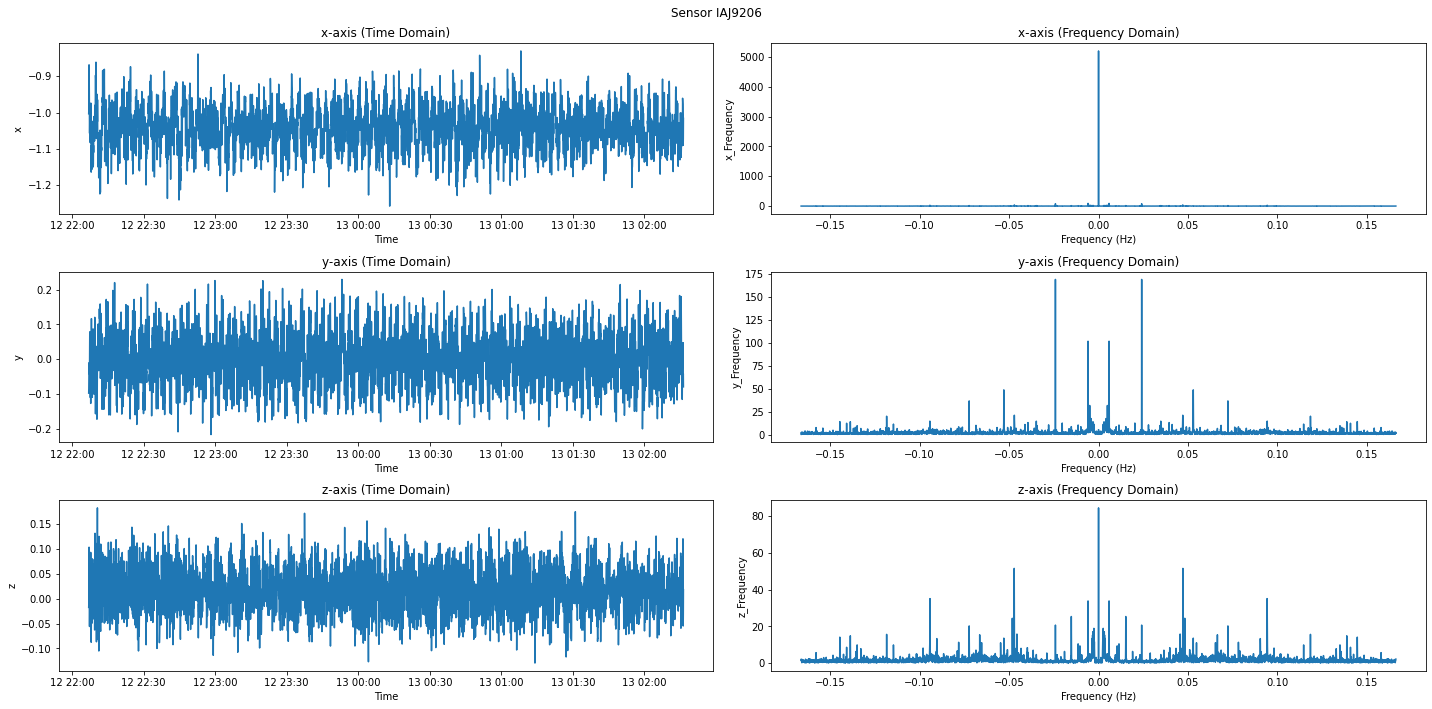

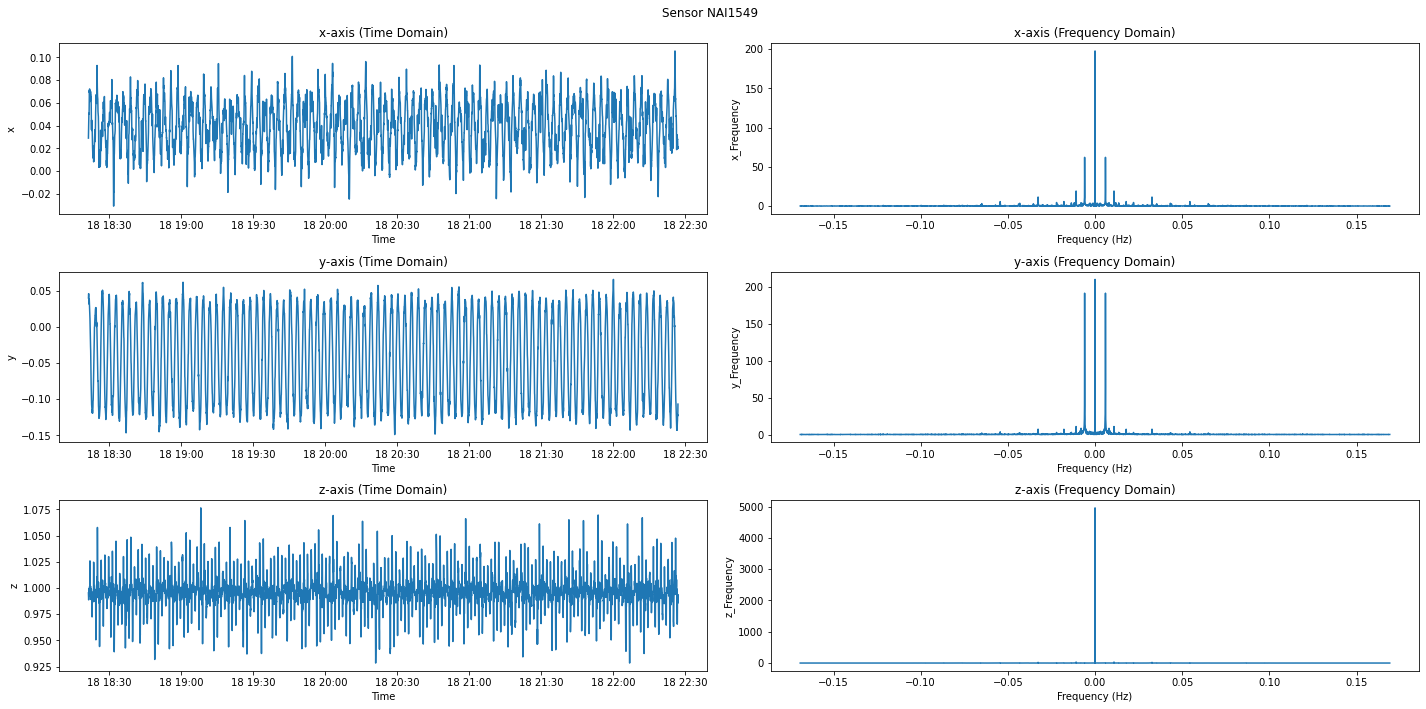

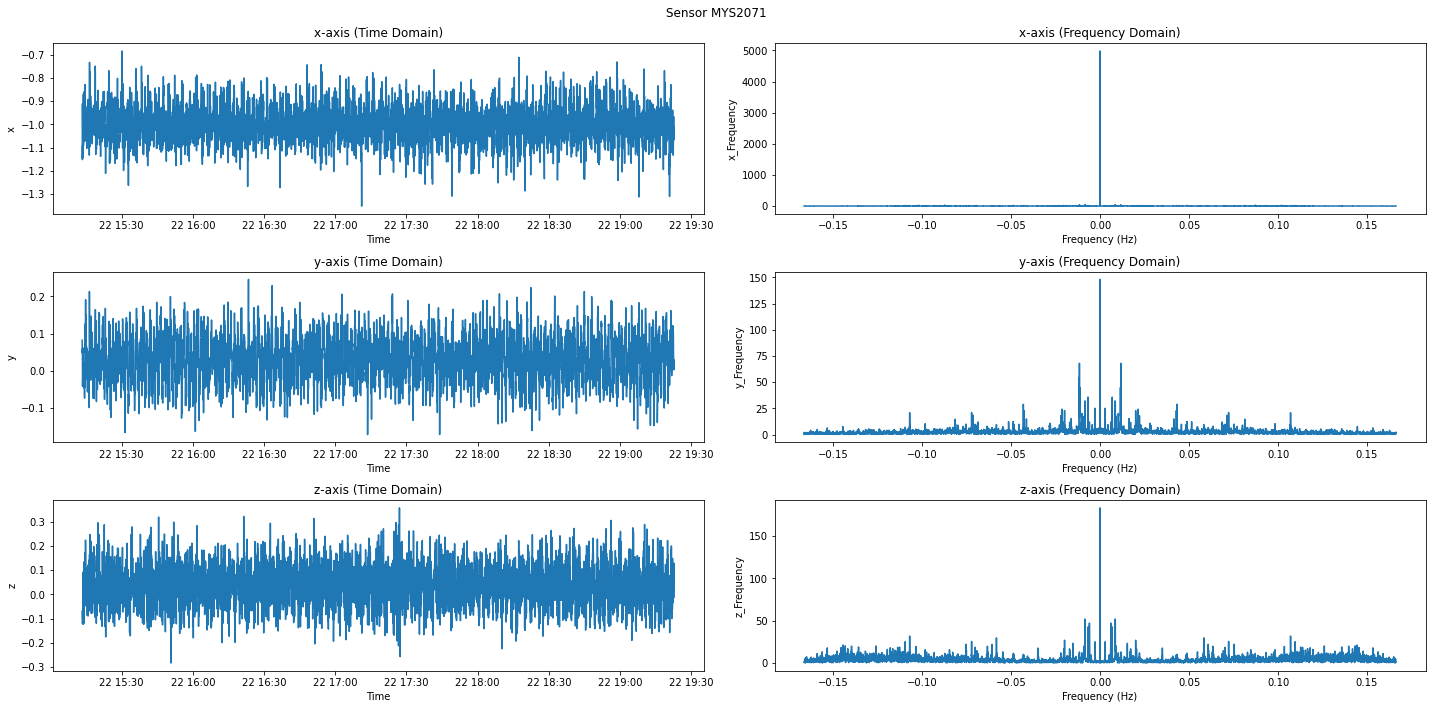

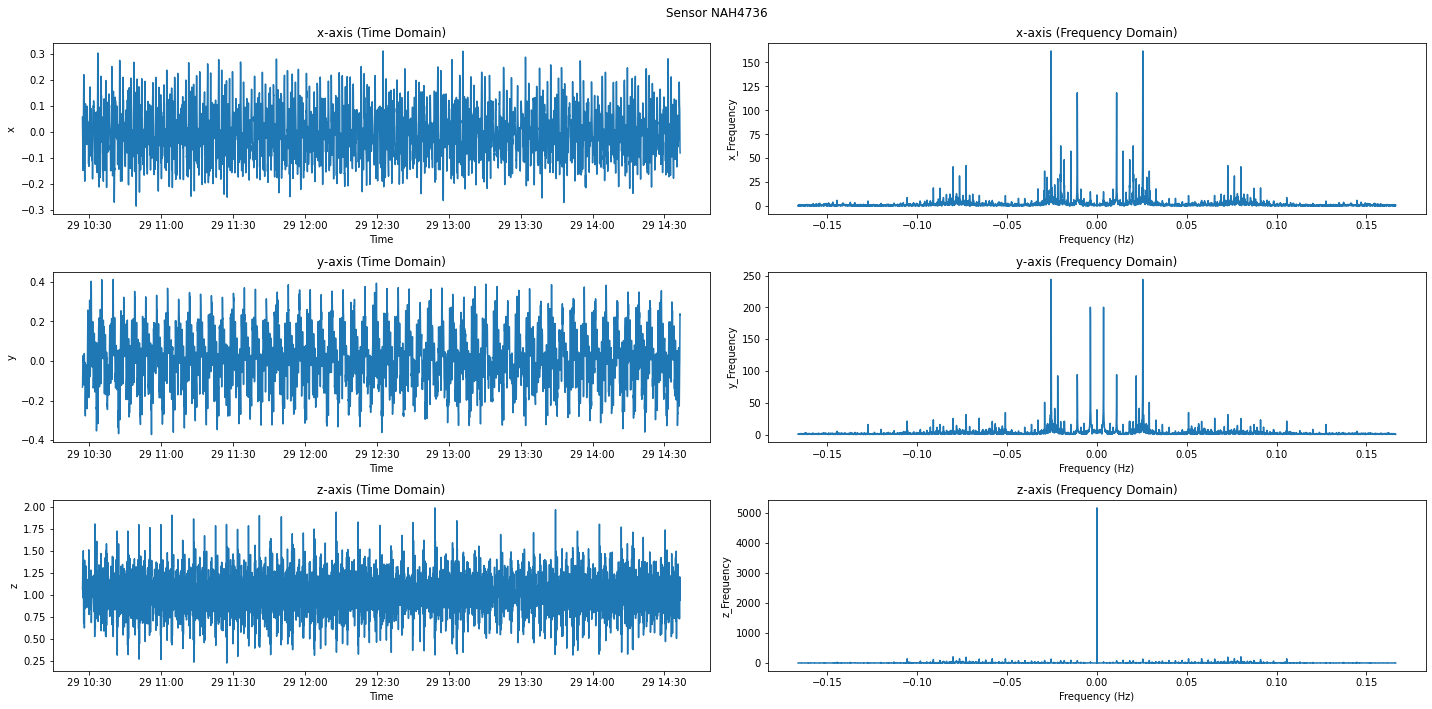

In [219]:
for file in files:
    df =  read_csv_file(data_path + file)

    # Specify the initial time and interval
    initial_time = int(file[:10]) # Initial time in epoch Unix format
    interval = int(file[11:15])   # Interval  between measurements in milliseconds
    sensor =  file[16:23]
    sample_freq = (1/interval)*1000
    cutoff_freq = 0.025

    # Convert to frequency domain
    data, freq = convert_to_frequency_domain(df, interval)
    # Plot accelerometer data
    plot_accelerometer_data(data, initial_time, interval, freq)


### Quetion 1 | Item C

- Para essa questão, podemos alterar a cutoff_freq para obter diferentes resultados quanto ao filtro lowpass que estamos aplicando
- O filtro lowpass foi escolhido pois os gráficos anteriores indicam que os sinais são compostos de frequencias majoritariamente baixas

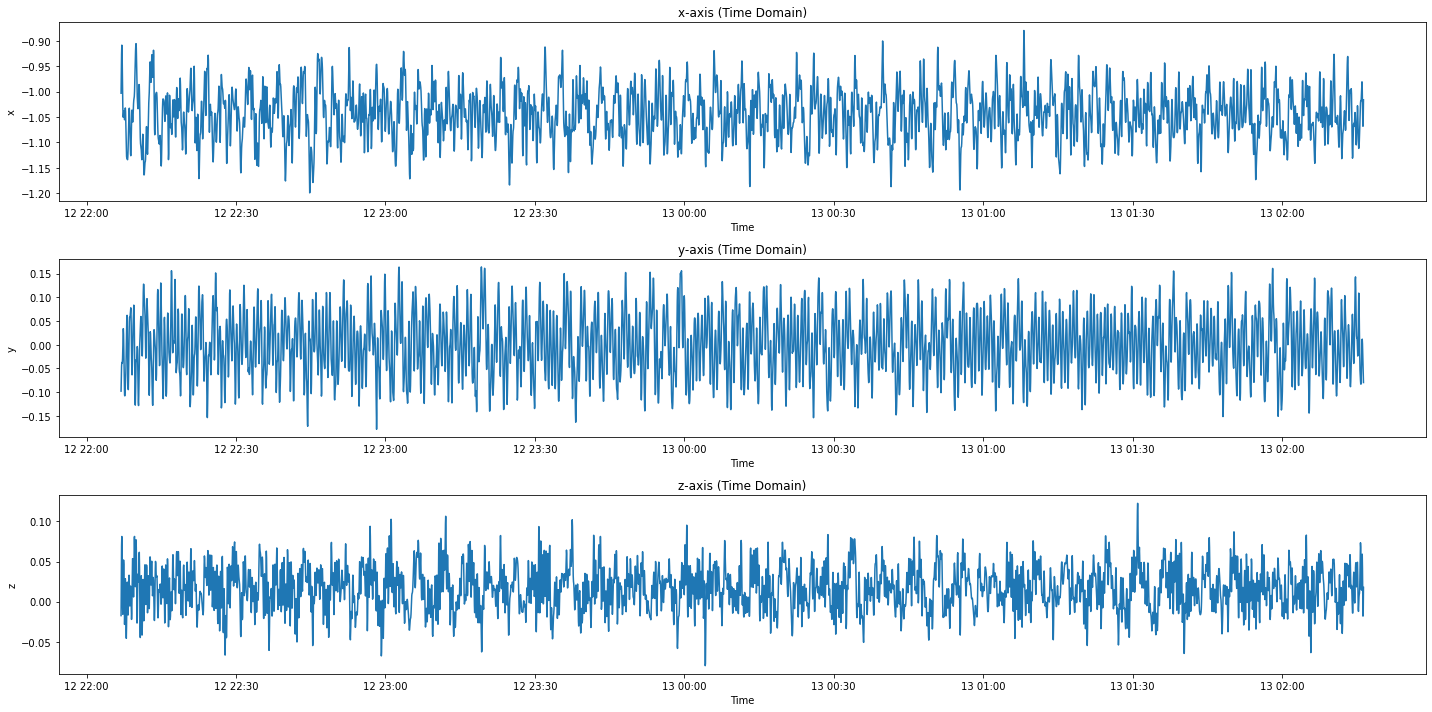

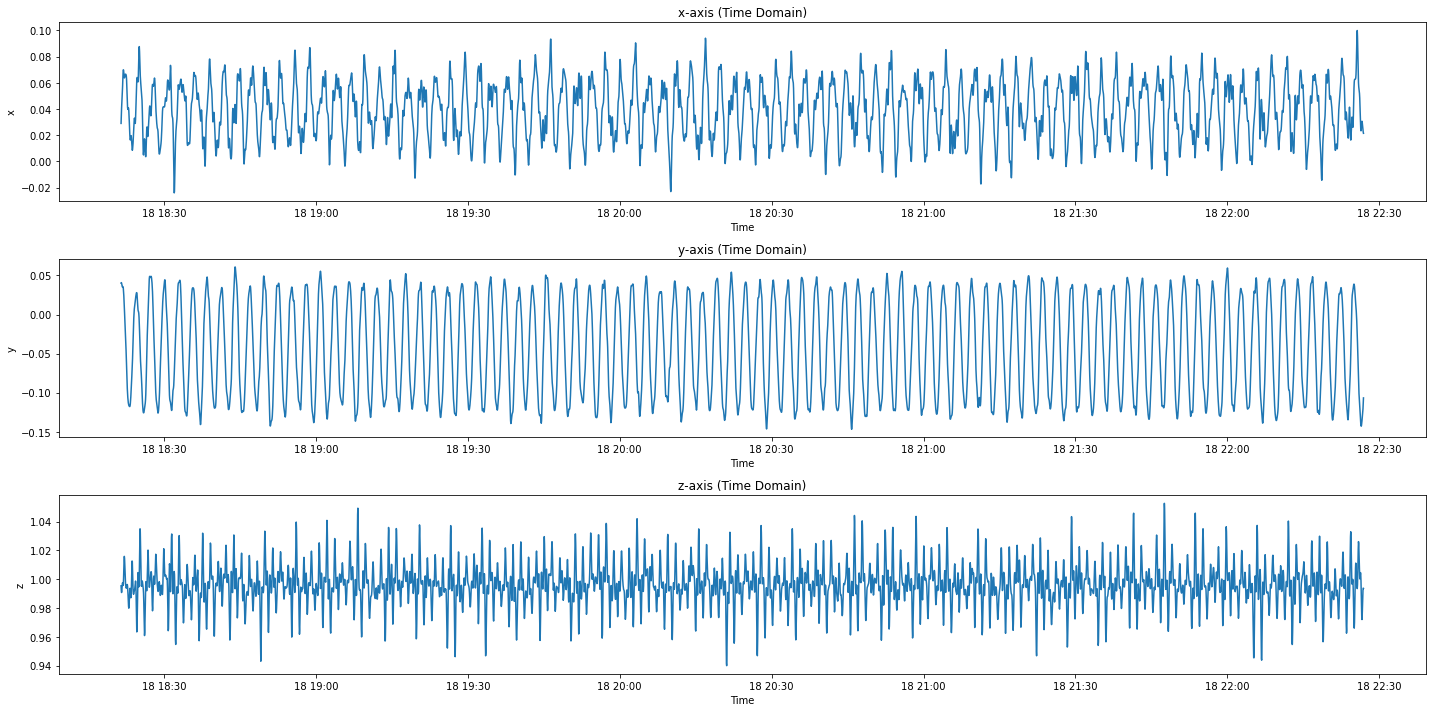

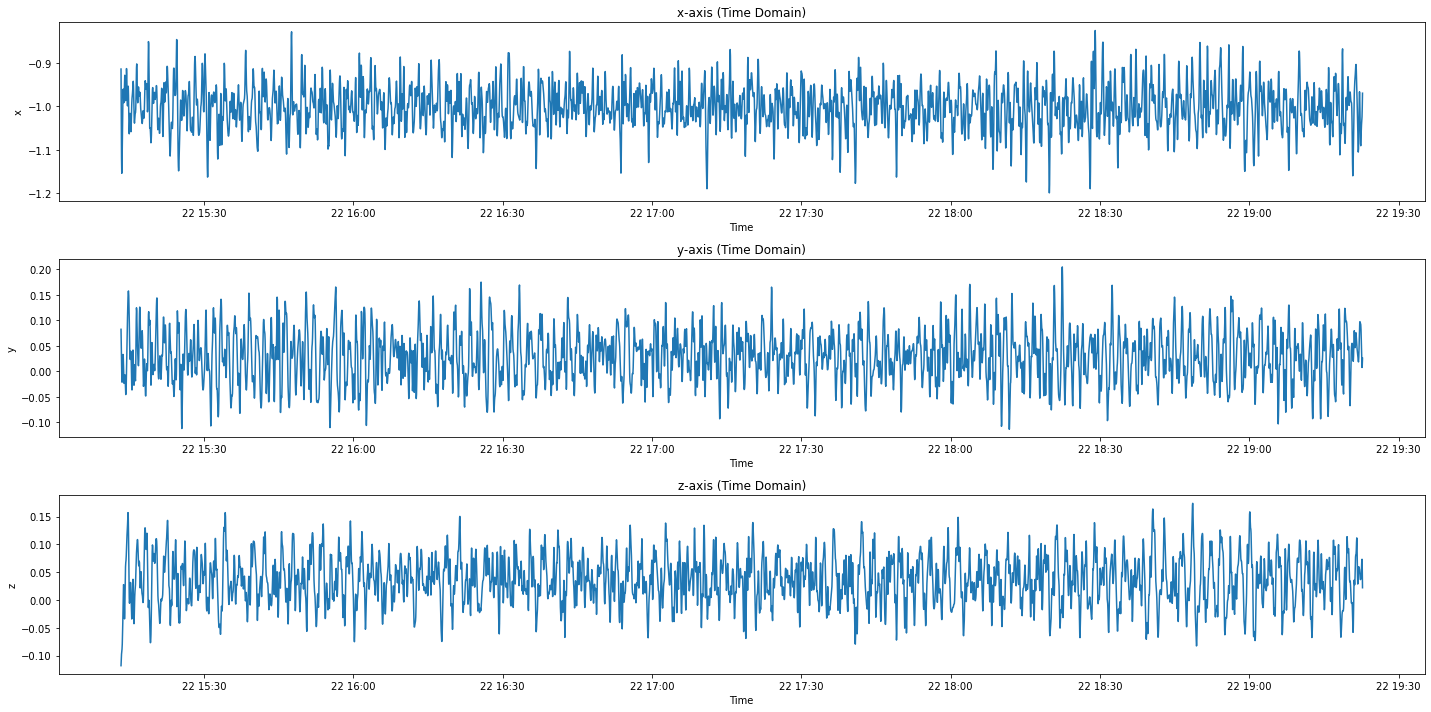

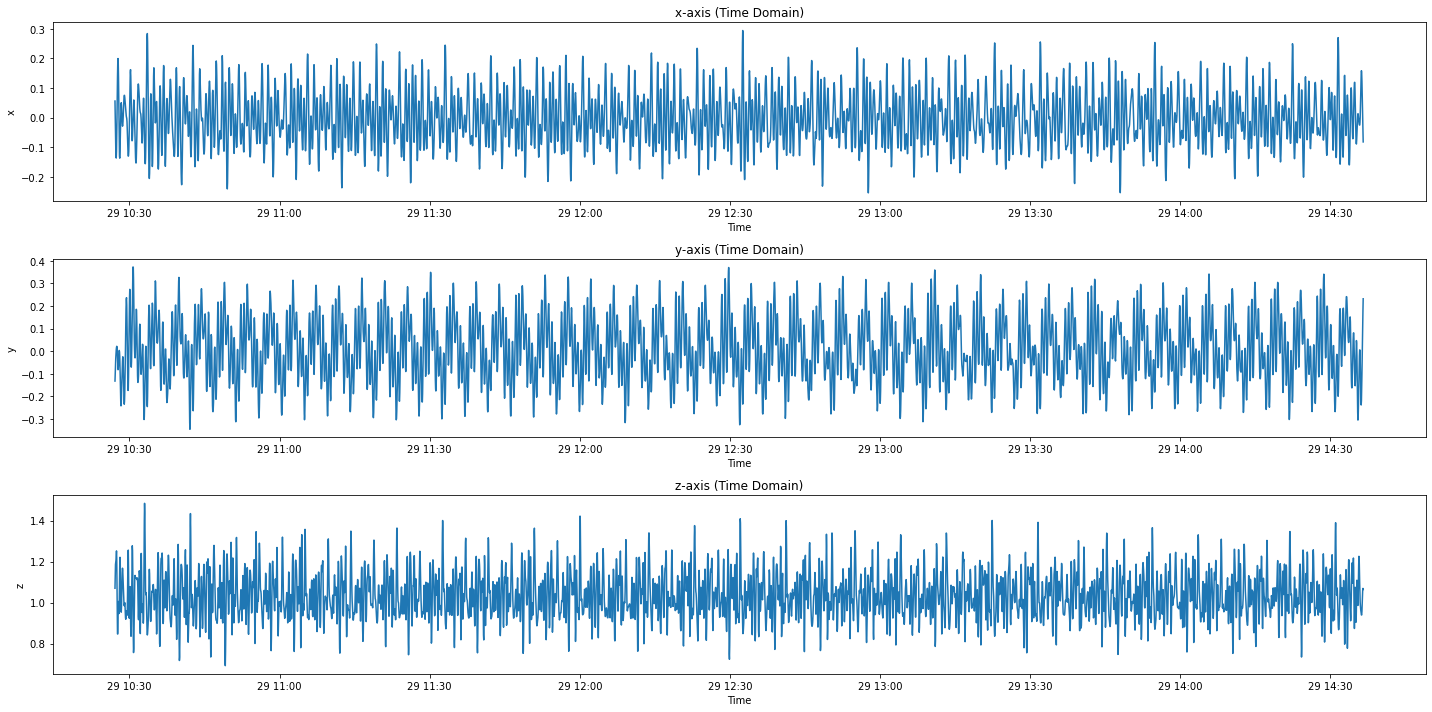

In [222]:

### For each graph we should use a different cutoff interval based on the previos graphs
for file in files:
    df =  read_csv_file(data_path + file)

    # Specify the initial time and interval
    initial_time = int(file[:10]) # Initial time in epoch Unix format
    interval = int(file[11:15])   # Interval  between measurements in milliseconds
    sensor =  file[16:23]
    sample_freq = (1/interval)*1000
    cutoff_freq = 0.05

    # Convert to frequency domain
    data, freq = convert_to_frequency_domain(df, interval)

    df_low = apply_lowpass_filter(data, cutoff_freq, sample_freq)

    plot_accelerometer_data_time(df_low, initial_time, interval)

###

### Part 2

In [109]:
data_path2 = 'data/part_2/'

In [224]:

## loading data and some basic preprocess 
df_collects = read_csv_file(data_path2 + 'collects.csv')
df_assets = read_csv_file(data_path2 + 'assets.csv')

df_assets.sensors = df_assets.sensors.apply(lambda x: re.sub(r'[\[\]""]', '', x))
df_collects.rename(columns = {'sensorId':'sensors'}, inplace = True)

df_collects['combined_acceleration'] = combine_rms_acceleration(df_collects)

In [225]:
# dropping null acceleration values
df_collects.dropna(inplace = True)
df_collects.reset_index(inplace = True, drop = True)
df_collects.head()

_id                 createdAt  params.accelRMS.x  \
0  60b57955f77013684c413e39  2021-06-01T00:03:33.370Z           0.010463   
1  60b57c53f77013684c41409f  2021-06-01T00:16:19.173Z           0.011437   
2  60b57f34f77013684c4142cd  2021-06-01T00:28:36.553Z           0.010494   
3  60b58237f77013684c41450c  2021-06-01T00:41:27.622Z           0.009859   
4  60b58515f77013684c414765  2021-06-01T00:53:41.450Z           0.010014   

   params.accelRMS.y  params.accelRMS.z  params.duration  params.sampRate  \
0           0.004463           0.011677            3.006      1656.686627   
1           0.004983           0.011482            3.006      1656.686627   
2           0.005024           0.011120            3.006      1656.686627   
3           0.004786           0.011096            3.006      1656.686627   
4           0.005213           0.011332            3.006      1656.686627   

   params.timeStart  params.velRMS.x  params.velRMS.y  params.velRMS.z  \
0      1.622506e+09         0.000511         0.000176         0.000289   
1      1.622507e+09         0.000633         0.000238         0.000292   
2      1.622507e+09         0.000524         0.000226         0.000246   
3      1.622508e+09         0.000437         0.000220         0.000248   
4      1.622509e+09         0.000501         0.000251         0.000275   

   sensors   temp  combined_acceleration  
0  IAJ9206  23.94               0.017106  
1  IAJ9206  23.19               0.016985  
2  IAJ9206  22.50               0.016509  
3  IAJ9206  22.87               0.016406  
4  IAJ9206  22.56               0.016852

### Question 2 | Item A

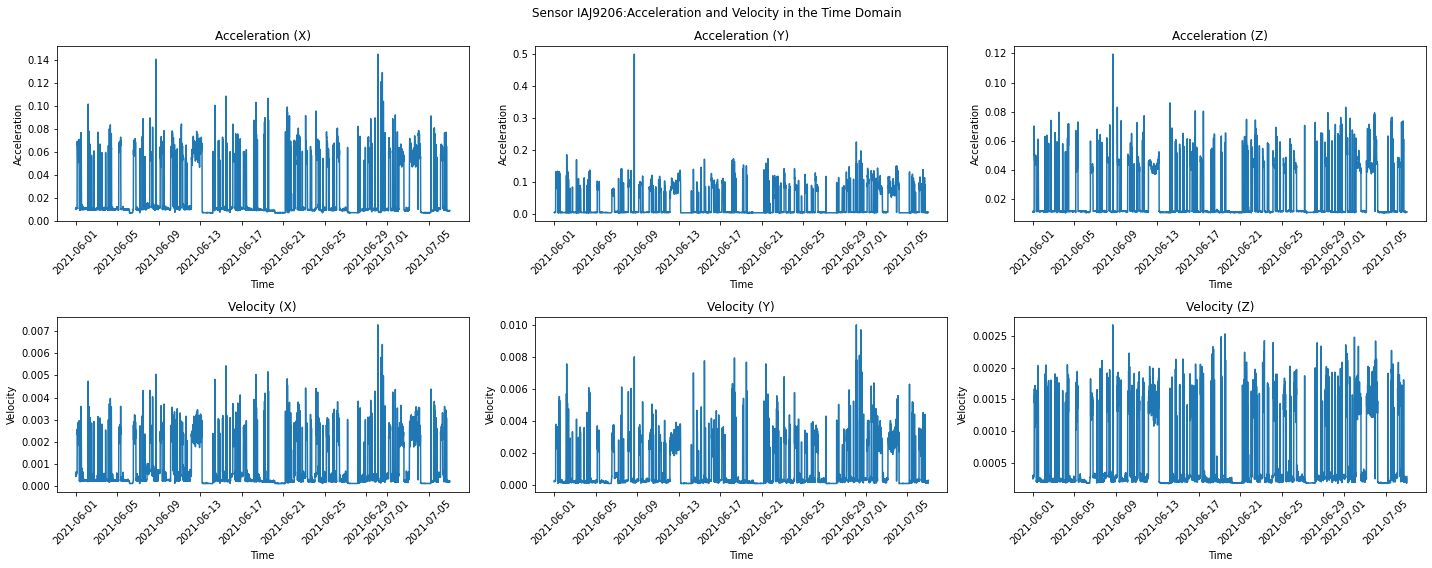

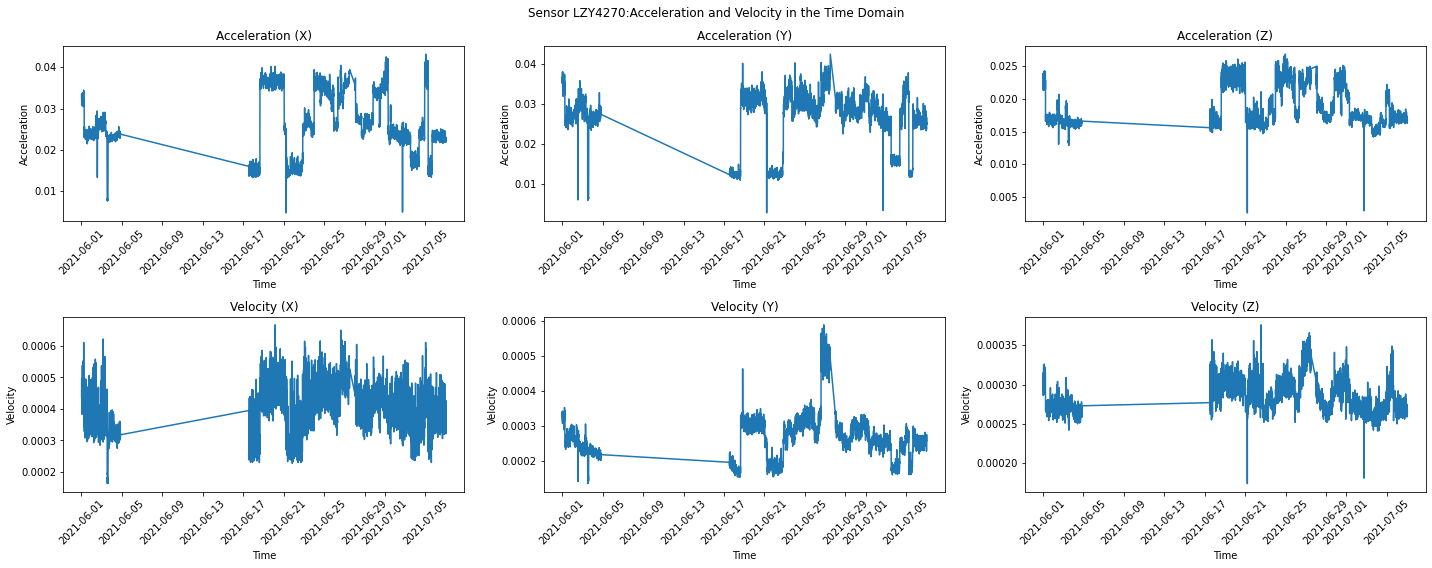

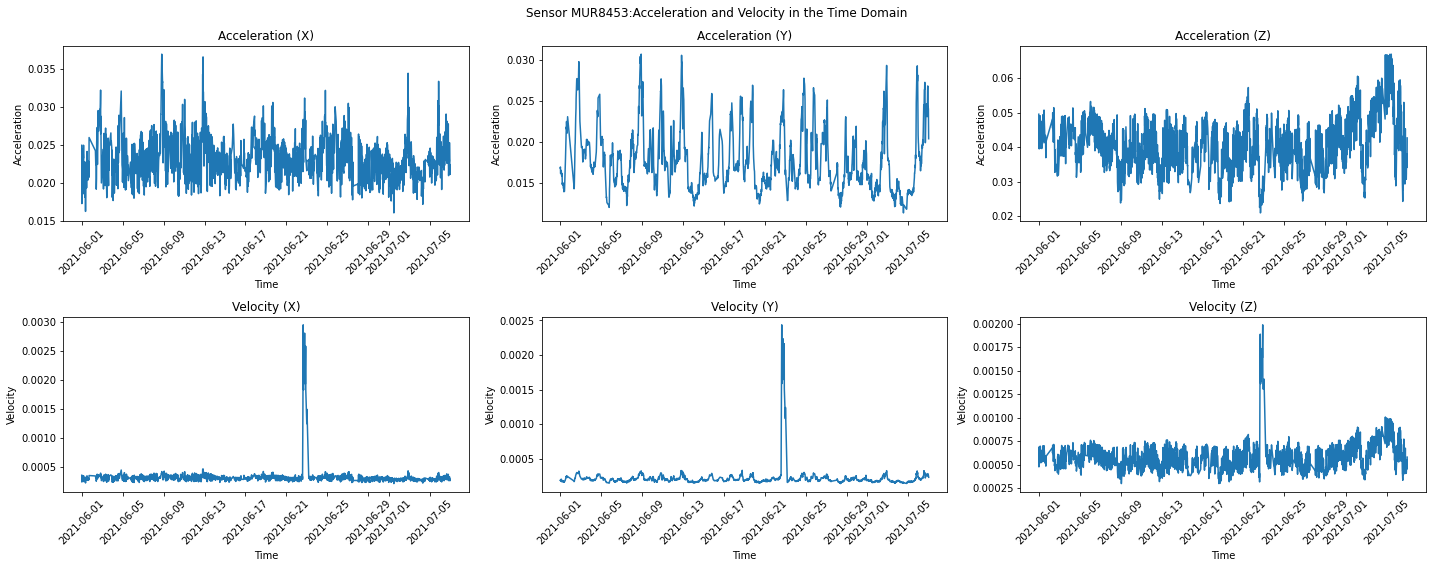

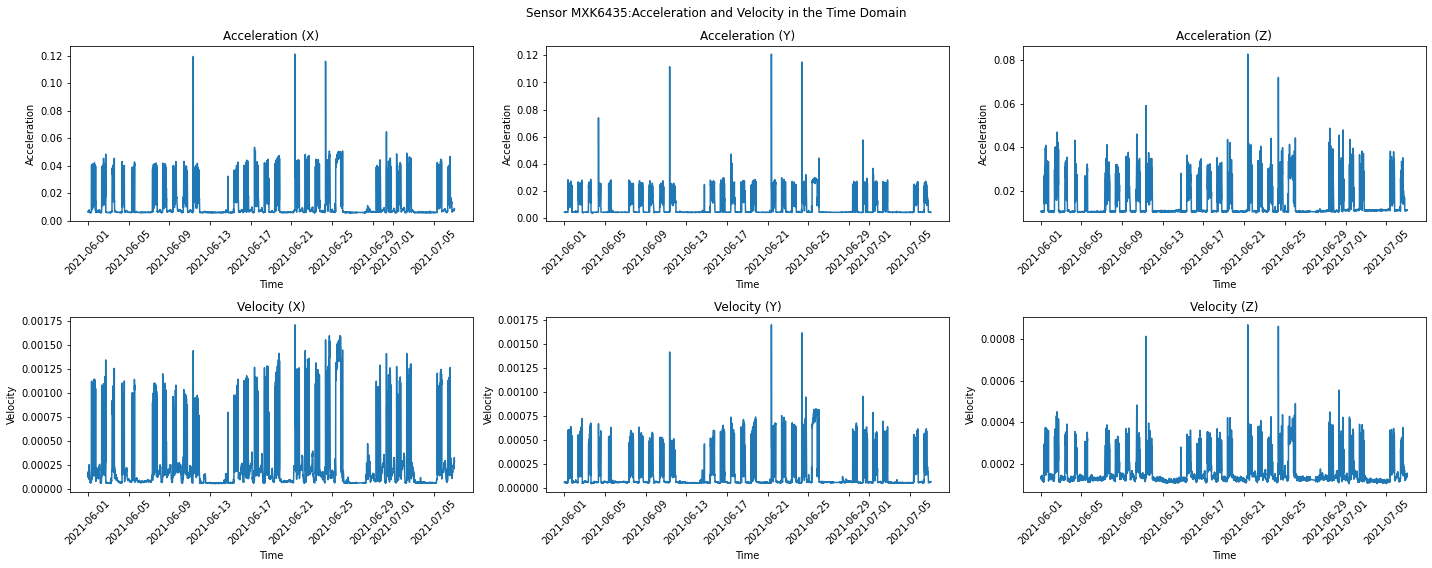

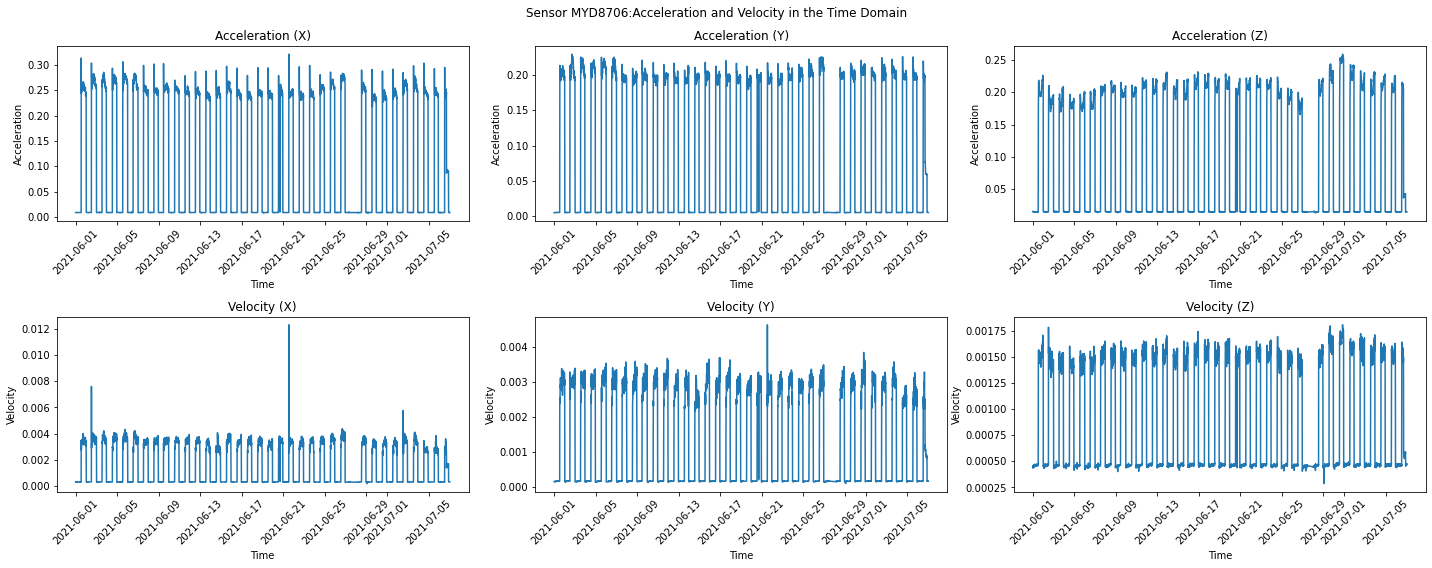

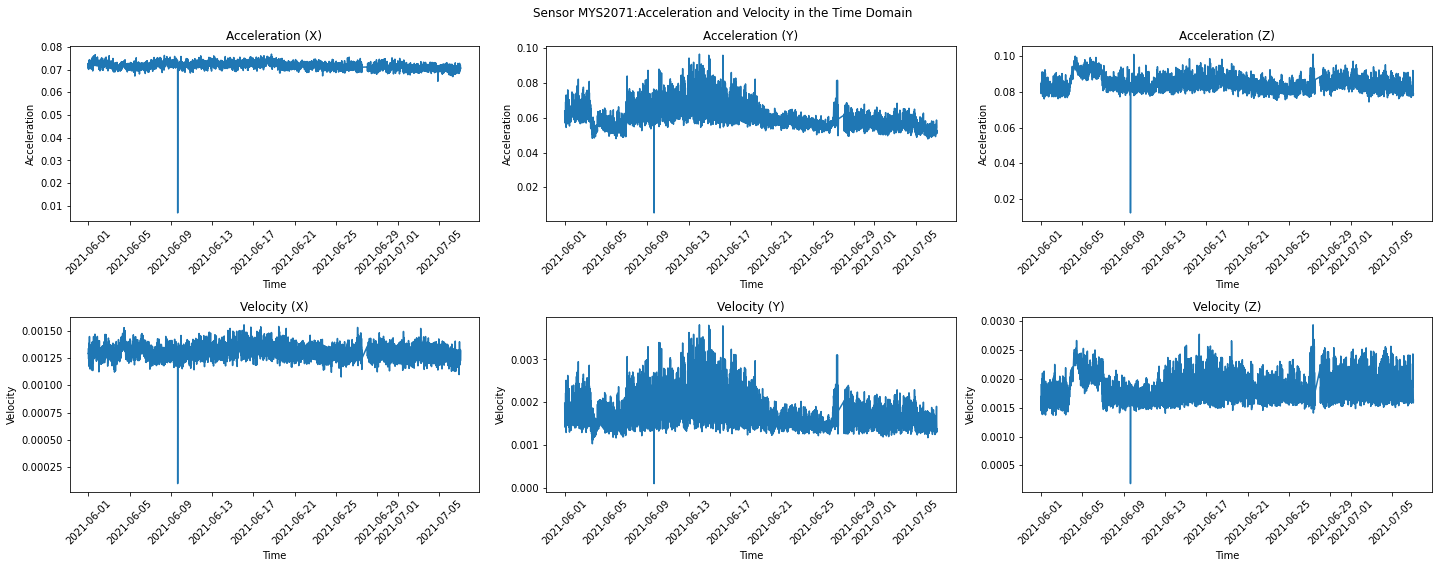

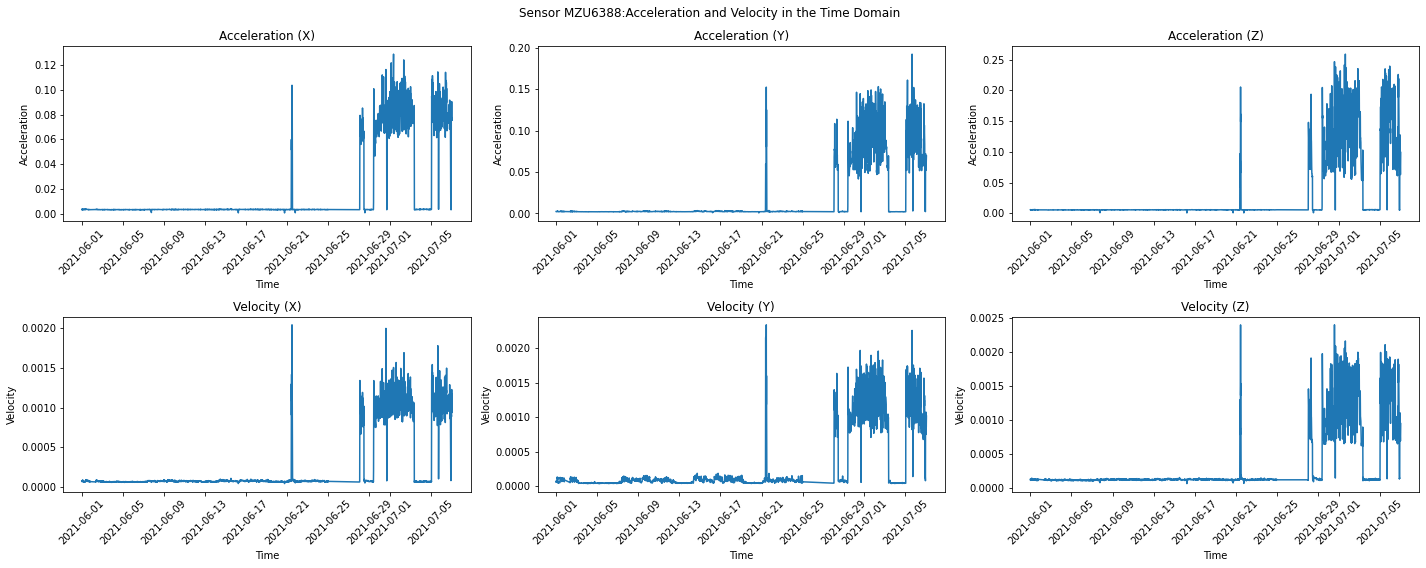

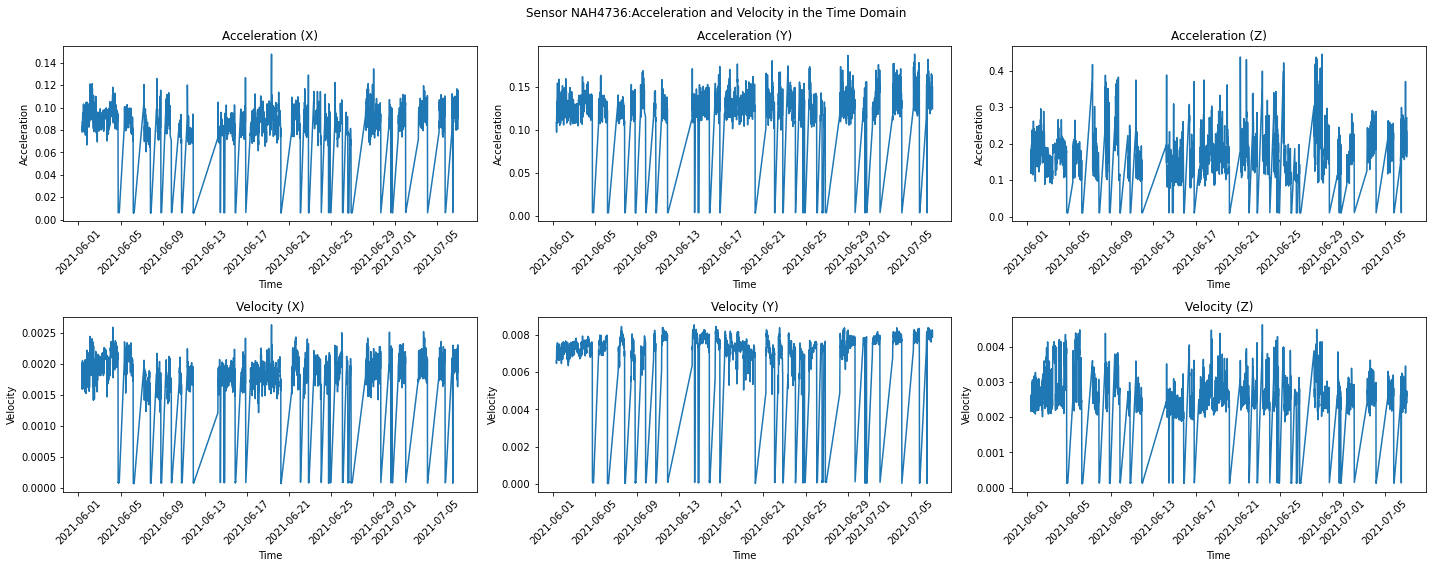

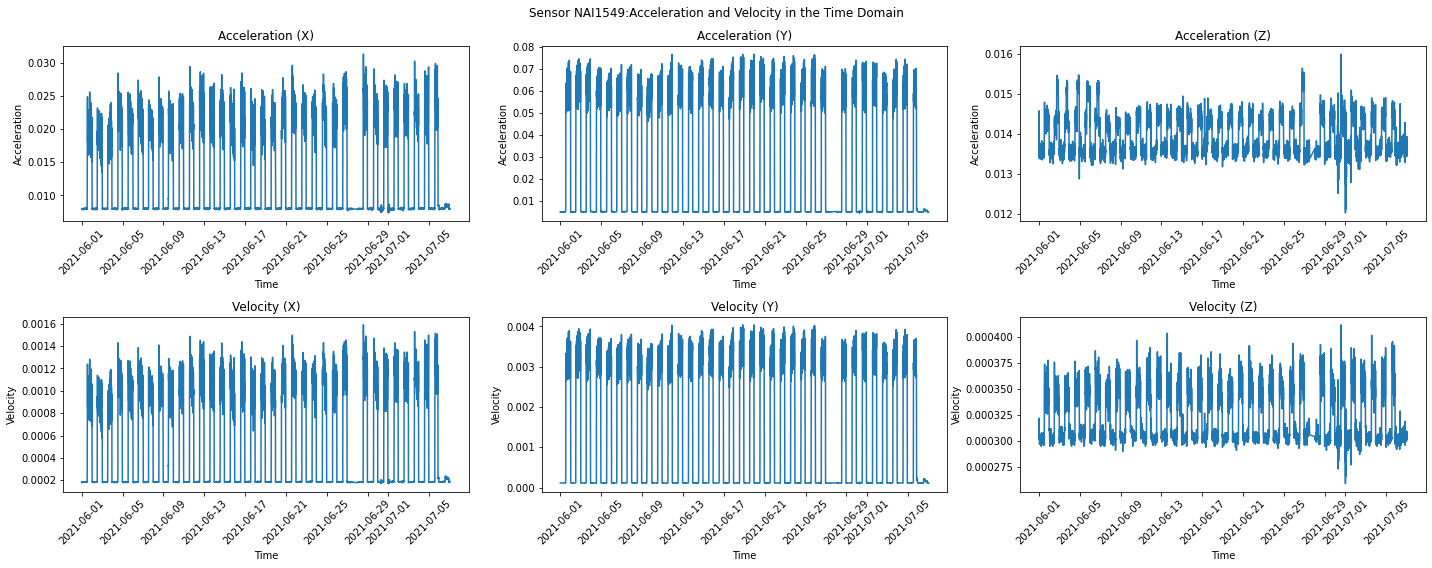

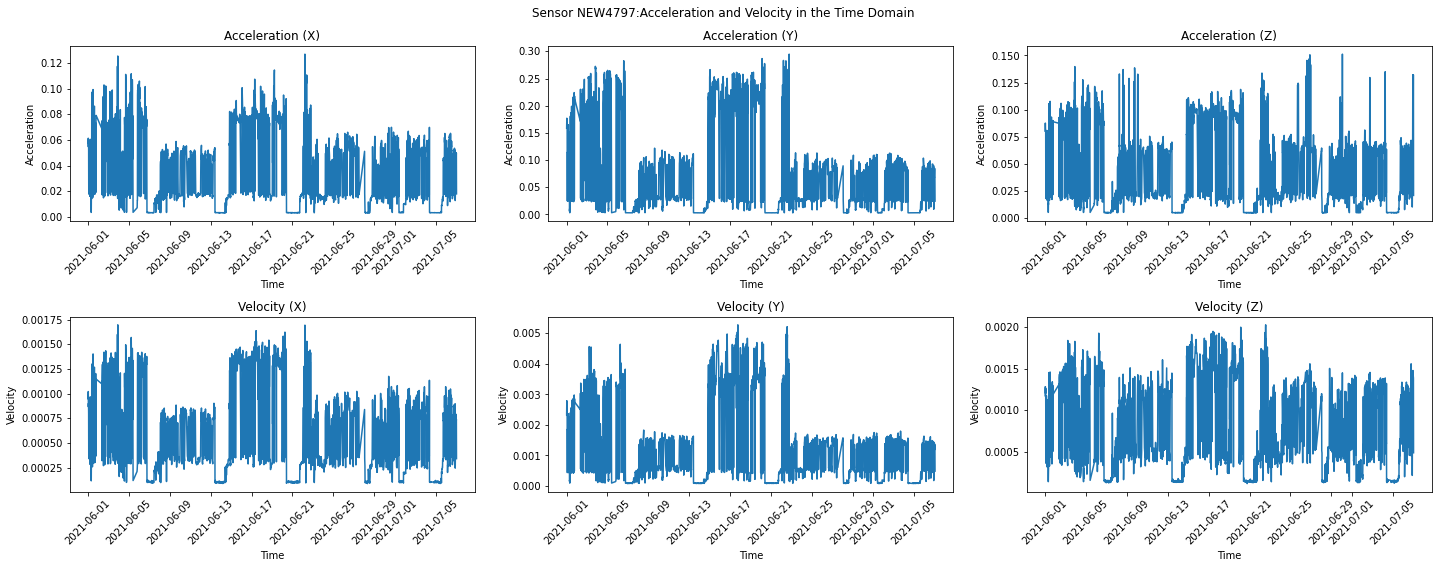

In [226]:
for sensor in df_collects.sensors.unique():
    df_collects.loc[df_collects.sensors == 'IAJ9206']
    plot_acceleration_velocity(df_collects.loc[df_collects.sensors == sensor], sensor)

### Question 2 | Item b

    - Aqui estou considerando que uptime e downtime são o tempos em medições em ativos ligados ou desligados
    - estou definindo o threshold de variação percentual em relação ao valor minimo de aceleração
    - assumption: no valor minimo de aceleração o ativo está desligado

In [228]:

### Aqui estou considerando que uptime e downtime são o tempos em medições em ativos ligados ou desligados
### estou definindo o threshold de variação percentual em relação ao valor minimo de aceleração
### assumption: no valor minimo de aceleração o ativo está desligado

threshold = 5
result_dict = {}

for sensor in df_collects.sensors.unique():
    df_temp = df_collects.loc[df_collects.sensors == sensor]
    ref_value = df_temp.combined_acceleration.min()

    #print(sensor)
    uptime, downtime = calculate_uptime_downtime(df_temp, ref_value, threshold)

    result_dict[sensor] = {'uptime':uptime, 'downtime':downtime}

pd.DataFrame(result_dict)

IAJ9206   LZY4270   MUR8453   MXK6435    MYD8706    MYS2071  \
uptime    10112.193  9001.004  9561.812  9369.702  12659.597  14293.532   
downtime   1689.397     4.001    14.242  2071.134     26.613      3.006   

            MZU6388   NAH4736    NAI1549   NEW4797  
uptime    11152.855  6817.717  12644.521  5419.237  
downtime      8.002   285.586      8.871   574.422

### Question 2 | Item C and D
    - Para essa questão proponho dois métodos:
        - Isolation Forest: que não performa muito bem para a maioria dos sensores
        - Z-Score: Podemos parametrizar a quantidade de desvios que queremos considerar e temos resultados interessantes utilizando 3 ou 4 desvios para a maioria dos sensores

### Isolation Forest

In [229]:
['IAJ9206', 'LZY4270', 'MUR8453', 'MXK6435', 'MYD8706', 'MYS2071',
'MZU6388', 'NAH4736', 'NAI1549', 'NEW4797']

sensor = 'NAI1549'

df_temp = df_collects.loc[df_collects.sensors == 'LZY4270']

# Apply outlier detection
outliers = detect_outliers_isolation_forest(df_temp)

# Count the number of outliers
num_outliers = outliers[outliers == -1].shape[0]
print(f"Number of outliers detected: {num_outliers}")


Number of outliers detected: 2340


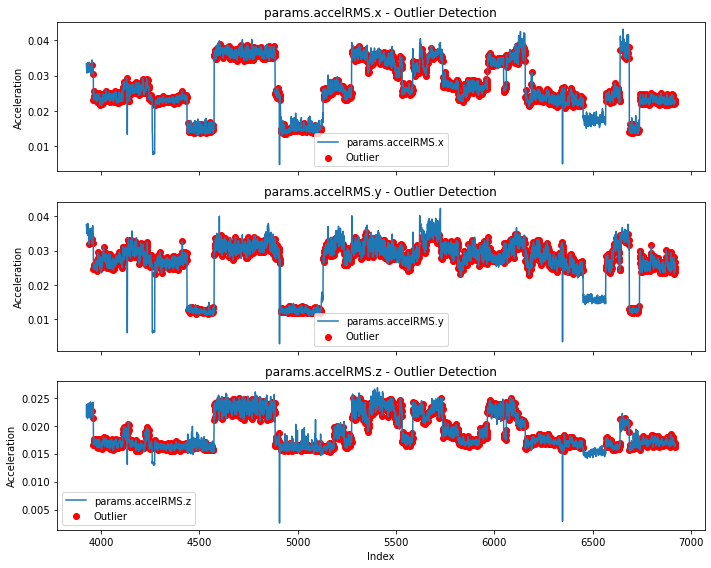

In [230]:
# Plot the data with outliers highlighted
plot_outliers_isolation(df_temp, outliers)


### Z-Score

In [231]:
['IAJ9206', 'LZY4270', 'MUR8453', 'MXK6435', 'MYD8706', 'MYS2071',
'MZU6388', 'NAH4736', 'NAI1549', 'NEW4797']

sensor = 'MUR8453'

df_temp = df_collects.loc[df_collects.sensors == sensor]

# Set the Z-score threshold
threshold = 3

# Apply Z-score outlier detection
outliers_zscore = detect_outliers_zscore(df_temp, threshold)

# Count the number of outliers
num_outliers_zscore = outliers_zscore.sum()
print(f"Number of outliers detected using Z-score: {num_outliers_zscore}")


Number of outliers detected using Z-score: 59


<ipython-input-210-e116bd756415>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x_column] = pd.to_datetime(df[x_column])


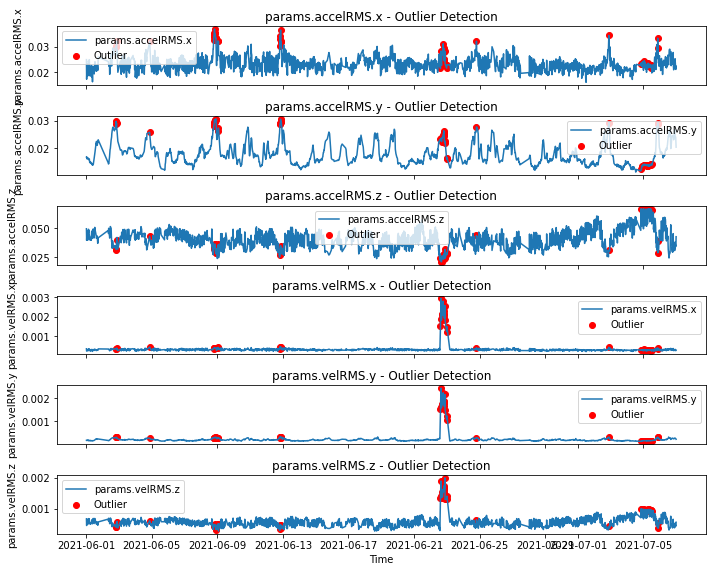

In [232]:
# Plot the data with outliers highlighted
plot_outliers(df_temp, outliers_zscore)